In [1]:
import json
import re
import spacy
import gensim
import tqdm
import logging

# Visualize LDA
import pyLDAvis
import pyLDAvis.sklearn
import pickle 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import GridSearchCV

# Construct the k-means clusters
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD

from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from pprint import pprint

/Users/yasser/anaconda3/envs/dataviz/lib/python3.7/site-packages/nltk/decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""


In [2]:
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt='%H:%M:%S', level=logging.INFO)

# Data preparation

In [3]:
df_subset = pd.read_pickle("../data/df_subset.pkl").sort_values(by=['Title']).reset_index().drop(columns='index')

In [4]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(simple_preprocess(str(sentence), deacc=True))

data = df_subset.Text_processed.values.tolist()
data_words = list(sent_to_words(data))

In [5]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=50)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        if len(allowed_postags) < 1:
            texts_out.append([token.lemma_ for token in doc])
        else:
            texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

INFO - 01:31:43: collecting all words and their counts
INFO - 01:31:43: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 01:31:48: collected 671735 word types from a corpus of 1609166 words (unigram + bigrams) and 937 sentences
INFO - 01:31:48: using 671735 counts as vocab in Phrases<0 vocab, min_count=5, threshold=50, max_vocab_size=40000000>
INFO - 01:31:48: collecting all words and their counts
INFO - 01:31:48: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 01:32:07: collected 696873 word types from a corpus of 1535548 words (unigram + bigrams) and 937 sentences
INFO - 01:32:07: using 696873 counts as vocab in Phrases<0 vocab, min_count=5, threshold=100, max_vocab_size=40000000>
INFO - 01:32:07: source_vocab length 671735
INFO - 01:32:20: Phraser built with 3579 phrasegrams
INFO - 01:32:20: source_vocab length 696873
INFO - 01:32:32: Phraser built with 5708 phrasegrams


In [6]:
data_words_nostops = remove_stopwords(data_words)
data_words_trigrams = make_trigrams(data_words_nostops)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [7]:
documents = [' '.join(doc) for doc in data_lemmatized]

# LDA

In [8]:
no_features = 1000

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tf = tf_vectorizer.fit_transform(documents)
tf_feature_names = tf_vectorizer.get_feature_names()

In [9]:
no_topics = 60

# Run LDA
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

In [10]:
# Show top n keywords for each topic
def show_topics(vectorizer, lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=tf_vectorizer, lda_model=lda, n_words=15)# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,methane,tree,school,year,day,plant,time,increase,claim,week,state,activity,editor,early,political
Topic 1,state,industry,group,say,oil,energy,include,farmer,vote,american,support,regulation,lobby,member,policy
Topic 2,diamond,cut,salt,form,carbon,pressure,high,temperature,color,crystal,produce,natural,know,surface,rock
Topic 3,trade,specie,wildlife,animal,ivory,cite,include,international,conservation,population,use,plant,import,market,product
Topic 4,soil,area,plant,material,tree,forest,carbon,specie,reduce,new,study,recycle,avoid,increase,large
Topic 5,lomborg,plant,science,work,public,climate,tree,book,year,scientist,author,day,publish,support,national
Topic 6,campaign,building,biofuel,increase,say,build,production,base,public,make,energy,performance,design,use,people
Topic 7,fuel,ecovillage,produce,use,ethanol,high,water,gas,biofuel,production,make,gasoline,energy,methanol,food
Topic 8,say,state,vote,support,election,member,campaign,government,make,include,year,law,federal,people,party
Topic 9,methane,release,use,emission,year,science,produce,increase,high,source,time,biofuel,climate,atmosphere,result


In [11]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, tf_feature_names, no_top_words)

Topic 0:
methane tree school year day plant time increase claim week
Topic 1:
state industry group say oil energy include farmer vote american
Topic 2:
diamond cut salt form carbon pressure high temperature color crystal
Topic 3:
trade specie wildlife animal ivory cite include international conservation population
Topic 4:
soil area plant material tree forest carbon specie reduce new
Topic 5:
lomborg plant science work public climate tree book year scientist
Topic 6:
campaign building biofuel increase say build production base public make
Topic 7:
fuel ecovillage produce use ethanol high water gas biofuel production
Topic 8:
say state vote support election member campaign government make include
Topic 9:
methane release use emission year science produce increase high source
Topic 10:
biogas use party film interview make include state say conservative
Topic 11:
failure gas methane water oil production movement engineering soil design
Topic 12:
soil methane claim say medium waste time us

In [12]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda.score(tf))
# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda.perplexity(tf))
# See model parameters
pprint(lda.get_params())

Log Likelihood:  -2472823.8216146925
Perplexity:  656.7499793547688
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 50.0,
 'max_doc_update_iter': 100,
 'max_iter': 5,
 'mean_change_tol': 0.001,
 'n_components': 60,
 'n_jobs': None,
 'perp_tol': 0.1,
 'random_state': 0,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [13]:
# Create Document — Topic Matrix
lda_output = lda.transform(tf)
# column names
topicnames = ["Topic" + str(i) for i in range(lda.n_components)]# index names
docnames = ["Doc" + str(i) for i in range(len(documents))]
# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 8), columns=topicnames, index=docnames)
# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic
# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,Topic20,Topic21,Topic22,Topic23,Topic24,Topic25,Topic26,Topic27,Topic28,Topic29,Topic30,Topic31,Topic32,Topic33,Topic34,Topic35,Topic36,Topic37,Topic38,Topic39,Topic40,Topic41,Topic42,Topic43,Topic44,Topic45,Topic46,Topic47,Topic48,Topic49,Topic50,Topic51,Topic52,Topic53,Topic54,Topic55,Topic56,Topic57,Topic58,Topic59,dominant_topic
Doc0,0.000137,0.000137,0.000137,0.000137,0.000137,0.000137,0.000137,0.000137,0.000137,0.000137,0.000137,0.000137,0.000137,0.000137,0.000137,0.000137,0.000137,0.000137,0.000137,0.000137,0.348547,0.000137,0.000137,0.000137,0.000137,0.000137,0.000137,0.000137,0.000137,0.000137,0.000137,0.000137,0.000137,0.000137,0.000137,0.000137,0.000137,0.000137,0.000137,0.000137,0.378320,0.040462,0.000137,0.000137,0.000137,0.000137,0.000137,0.000137,0.000137,0.000137,0.000137,0.000137,0.000137,0.000137,0.000137,0.000137,0.000137,0.000137,0.000137,0.225021,40
Doc1,0.001389,0.001389,0.001389,0.001389,0.001389,0.001389,0.001389,0.001389,0.001389,0.001389,0.001389,0.001389,0.001389,0.001389,0.001389,0.001389,0.001389,0.001389,0.001389,0.001389,0.918056,0.001389,0.001389,0.001389,0.001389,0.001389,0.001389,0.001389,0.001389,0.001389,0.001389,0.001389,0.001389,0.001389,0.001389,0.001389,0.001389,0.001389,0.001389,0.001389,0.001389,0.001389,0.001389,0.001389,0.001389,0.001389,0.001389,0.001389,0.001389,0.001389,0.001389,0.001389,0.001389,0.001389,0.001389,0.001389,0.001389,0.001389,0.001389,0.001389,20
Doc2,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.022560,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.004887,0.000008,0.000008,0.000008,0.000008,0.000008,0.921693,0.038382,0.012023,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,39
Doc3,0.000028,0.000028,0.000028,0.554871,0.000028,0.000028,0.000028,0.000028,0.137370,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.037489,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.077029,0.000028,0.000028,0.000028,0.191706,0.000028,0.000028,0.000028,0.000028,0.000028,3
Doc4,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.110300,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.488645,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.398132,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,21
Doc5,0.000059,0.000059,0.000059,0.000059,0.000059,0.000059,0.000059,0.000059,0.000059,0.000059,0.000059,0.000059,0.000059,0.000059,0.000059,0.000059,0.000059,0.000059,0.000059,0.000059,0.813405,0.000059,0.000059,0.000059,0.000059,0.000059,0.000059,0.000059,0.000059,0.000059,0.000059,0.000059,0.000059,0.000059,0.000059,0.000059,0.000059,0.000059,0.000059,0.000059,0.000059,0.000059,0.000059,0.000059,0.000059,0.000059,0.000059,0.000059,0.000059,0.000059,0.148276,0.000059,0.000059,0.000059,0.000059,0.000059,0.000059,0.000059,0.000059,0.034950,20
Doc6,0.000309,0.000309,0.000309,0.000309,0.000309,0.000309,0.000309,0.000309,0.000309,0.000309,0.000309,0.000309,0.000309,0.000309,0.000309,0.000309,0.000309,0.000309,0.000309,0.000309,0.000309,0.416321,0.000309,0.000309,0.0003

In [14]:
clusters = KMeans(n_clusters=15, random_state=100).fit_predict(lda_output)
# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)# 2 components
lda_output_svd = svd_model.fit_transform(lda_output)
# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]
#Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))
# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.    0.    0.    0.02  0.    0.    0.    0.    0.76  0.    0.    0.
   0.    0.    0.02  0.01  0.    0.    0.    0.    0.17  0.46  0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.01  0.    0.23  0.    0.
   0.    0.    0.    0.05  0.03  0.1   0.    0.01  0.    0.    0.    0.
   0.    0.    0.31  0.    0.    0.    0.11  0.    0.    0.    0.    0.13]
 [ 0.    0.    0.01  0.01  0.    0.    0.    0.   -0.48  0.    0.    0.
   0.    0.    0.02  0.01  0.    0.    0.    0.    0.53  0.03  0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.01 -0.    0.    0.    0.
   0.    0.    0.    0.05  0.05  0.28  0.    0.    0.    0.    0.    0.
   0.    0.    0.59  0.    0.    0.    0.16  0.    0.    0.    0.    0.18]]
Perc of Variance Explained: 
 [0.07 0.15]


Text(0.5, 1.0, 'Segregation of Topic Clusters')

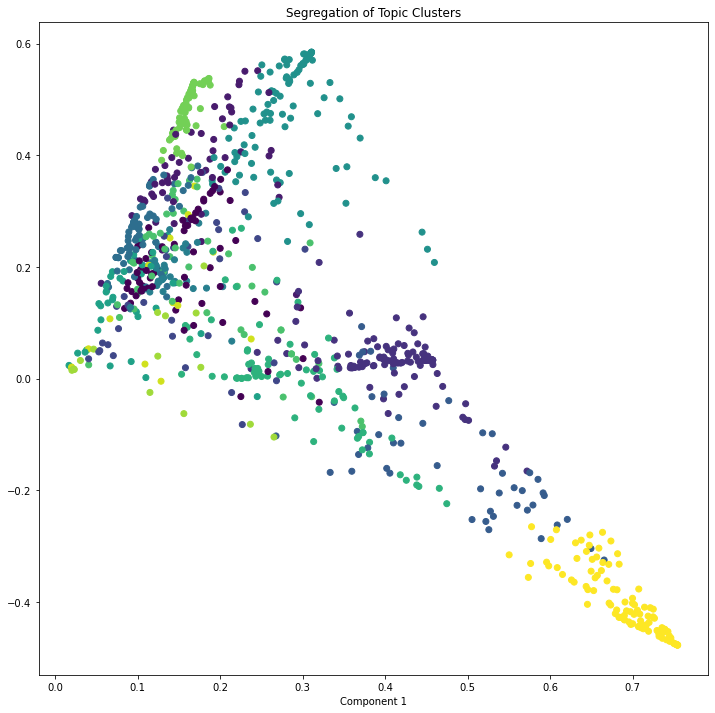

In [15]:
# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

In [16]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
def similar_documents(text, doc_topic_probs, documents = data, nlp=nlp, top_n=5, verbose=False):
    topic, x  = predict_topic(text)
    dists = euclidean_distances(x.reshape(1, -1), doc_topic_probs)[0]
    doc_ids = np.argsort(dists)[:top_n]
    if verbose:        
        print("Topic KeyWords: ", topic)
        print("Topic Prob Scores of text: ", np.round(x, 1))
        print("Most Similar Doc's Probs:  ", np.round(doc_topic_probs[doc_ids], 1))
    return doc_ids, np.take(documents, doc_ids)

In [17]:
sims = cosine_similarity(lda_output, lda_output)

In [18]:
sims[0]

array([1.00000000e+00, 6.20881015e-01, 2.91468318e-02, 4.79286028e-04,
       5.20463879e-04, 6.25570289e-01, 1.11961666e-03, 5.86015401e-01,
       3.93481771e-01, 8.46782504e-03, 2.56969887e-02, 7.57610806e-02,
       6.19718828e-01, 4.55658370e-03, 1.24423831e-03, 7.89533159e-01,
       3.66604929e-02, 6.38606047e-02, 6.28636735e-04, 5.67388788e-04,
       2.70505126e-04, 6.17991895e-01, 2.80093553e-02, 1.72365779e-01,
       5.85945362e-02, 5.62114781e-04, 5.51965354e-02, 6.18248155e-04,
       1.11370374e-03, 3.16441112e-01, 3.66791247e-01, 4.78151656e-01,
       2.35458999e-03, 4.31568832e-04, 5.83046015e-04, 3.67986901e-04,
       4.77203065e-04, 3.10221443e-04, 9.82709180e-04, 2.61149156e-01,
       3.64702068e-02, 2.43796072e-01, 2.99379436e-03, 6.81428789e-01,
       2.94076016e-04, 2.94076016e-04, 3.94629875e-04, 3.99273694e-01,
       4.61500911e-04, 2.44719563e-02, 5.30347830e-01, 6.28184643e-01,
       6.27056973e-04, 4.97543280e-04, 4.03417837e-01, 4.28052137e-03,
      

In [19]:
df_sims = df_subset[['Title', 'Text_processed']].copy()
df_sims['Dominant Topic'] = dominant_topic
df_sims['Sims'] = sims.tolist()

In [20]:
df_sims.head()

,Title,Text_processed,Dominant Topic,Sims
0,"2,5-Dimethylfuran","2,5-dimethylfuran is a heterocyclic compound w...",40,"[1.0000000000000002, 0.6208810150204145, 0.029..."
1,2-Methylfuran,"2-methylfuran, also known with the older name ...",20,"[0.6208810150204145, 1.0000000000000024, 0.001..."
2,2007–08 world food price crisis,world food prices increased dramatically in 20...,39,"[0.02914683177495991, 0.0016481418417907804, 0..."
3,ASEAN Wildlife Enforcement Network,the asean wildlife enforcement network (asean-...,3,"[0.00047928602761282814, 0.002529903057432023,..."
4,Accuracy in Media,accuracy in media (aim) is an american non-pro...,21,"[0.0005204638786978396, 0.0024441338682554127,..."


In [21]:
df_sims.to_csv("../data/df_lda_sims.csv")
df_topic_keywords.to_csv("../data/df_lda_topics.csv")